In [53]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

# Custom module to create synthetic dataset
from utils.sine_dataset import signal_dataset_harmonic_creator


In [54]:
# LSTM parameters
hidden_dim = 20
n_signals = 1
N = 64
tagset_size = 1


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


cpu


In [55]:
# Model creation
class LSTMHarmonic(nn.Module):
    """Some Information about LSTMHarmonic"""

    def __init__(self, N, hidden_dim, tagset_size):
        super(LSTMHarmonic, self).__init__()
        self.lstm = nn.LSTM(N, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, tagset_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        fc_layer = self.fc(lstm_out[:, -1, :])

        return torch.sigmoid(fc_layer)



model = LSTMHarmonic(n_signals, hidden_dim, tagset_size).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
print(f"Model structure: {model}\n")

Model structure: LSTMHarmonic(
  (lstm): LSTM(1, 20, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)



In [56]:
# Define Dataset Class
class SineWaveDataset(torch.utils.data.Dataset):
    """Some Information about SineWaveDataset"""

    def __init__(self, signals, labels, transform=None, labels_transform=None):
        super(SineWaveDataset, self).__init__()
        self.signals = signals
        self.labels = labels
        self.transform = transform
        self.labels_transform = labels_transform

    def __getitem__(self, index):
        signal = self.signals[index]
        label = self.labels[index]
        if self.transform:
            signal = self.transform(signal)
        if self.labels_transform:
            label = self.labels_transform(label)
        return signal, label

    def __len__(self):
        return len(self.signals)

In [57]:
# Dataset Parameters
fs = 3840
N = 64
m = 2200

# Create Dataset Signals
signals, target = signal_dataset_harmonic_creator(fs, N, m)
signals = np.expand_dims(signals, axis=2)
signals = torch.from_numpy(signals).float()
target = torch.from_numpy(target).float()

# Create Dataset instance

dataset = SineWaveDataset(signals, target)
train_dataset, test_dataset, val_dataset = random_split(dataset, [0.9, 0.09, 0.01])
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True)


In [58]:
# Create Training / Test / Validation Loops

# Training
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        # Compute prediction error
        pred = model(x)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(x)
            print(f"loss: {loss:>f} [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (torch.round(pred) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n"
    )


In [59]:
epochs = 1
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n--------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
--------------------------------
loss: 0.690494 [    0/ 2639]
loss: 0.537032 [  640/ 2639]
loss: 0.246786 [ 1280/ 2639]
loss: 0.137101 [ 1920/ 2639]
loss: 0.233016 [ 2560/ 2639]
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.179115 



In [60]:
# Save the Model
# torch.save(model.state_dict(), './models/LSTMHarmonic_weights.pth')
model.load_state_dict(torch.load('./models/LSTMHarmonic_weights.pth'))


<All keys matched successfully>

tensor([[0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])
torch.Size([16, 64, 1])
tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]], grad_fn=<RoundBackward0>)


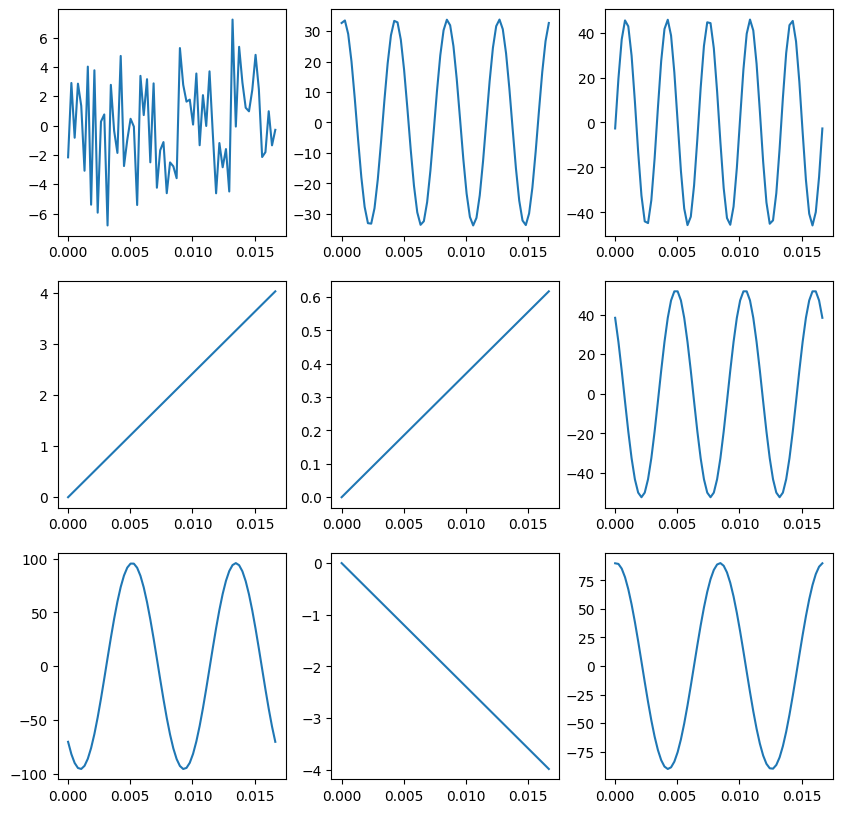

In [61]:
dataiter = iter(val_dataloader)
signal, labels = next(dataiter)
t = np.linspace(0, N / fs, N)
print(labels[1:10])
print(signal.shape)
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    figure.add_subplot(rows, cols, i)
    plt.plot(t, signal[i, :, 0])
x = model(signal[1:10].to(device))
print(torch.round(x))


In [62]:
from utils.sine_dataset import (
    sine_phase_creator,
    sine_creator,
    gaussian_creator,
    constant_creator,
    sine_noise,
    sine_harmonics
)

fs = 3840
N = 64
m = 100
t = np.linspace(0, N / fs, N)
signals_prueba = t
target_prueba = np.array([0])


In [63]:
signals_prueba, _ = sine_harmonics(
    signals_prueba, target_prueba, t, fs, m, mag_i=10_000, mag_f=10_000_000, harmonics=6
)
signals_prueba = np.expand_dims(signals_prueba, axis=2)
signals_prueba = torch.from_numpy(signals_prueba).float()
print(signals_prueba.shape)
print(signals_prueba.shape)
x = model(signals_prueba.to(device))

print(torch.round(x))


torch.Size([84, 64, 1])
torch.Size([84, 64, 1])
tensor([[0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],


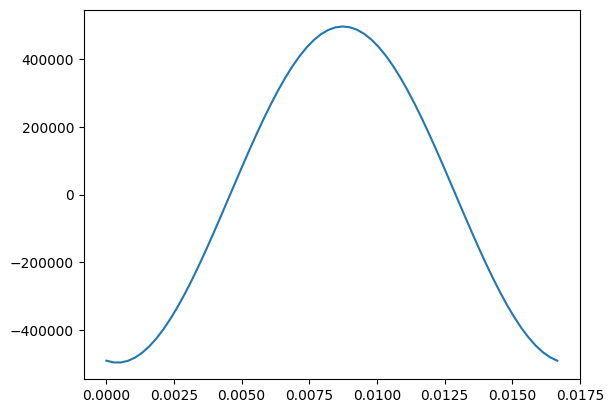

In [64]:
# Cambiar el índice [x, :, 0], para poder ver distintas señales
plt.plot(t, signals_prueba[5, :, 0])
